<a href="https://colab.research.google.com/github/ttya16/ImageClassifier/blob/master/ImageClassifier_using_tf(keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ImageDataGeneratorを用いた画像分類モデルの例
kerasのImageDataGeneratorを用いて、ネットから検索した画像の分類モデルを作ってみた。
<br>
ここでは例として麻婆豆腐かカレーの分類を行う。


画像収集はGoogleAPIを用いた方法で行った。
[参考記事]("https://qiita.com/onlyzs/items/c56fb76ce43e45c12339")



In [0]:
import urllib.request
from urllib.parse import quote
import httplib2
import json 
import os

GoogleAPI key

In [0]:
API_KEY =None
CUSTOM_SEARCH_ENGINE = None

訓練用画像データファイルを格納するフォルダを作成

In [12]:
!mkdir train
!mkdir train/mabo
!mkdir train/curry
!mkdir valid
!mkdir valid/mabo
!mkdir valid/curry



mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘train/mabo’: File exists
mkdir: cannot create directory ‘train/curry’: File exists


In [0]:
def get_image_url(search_item, total_num):
    img_list = []
    i = 0
    #一度に取得できる画像数は10枚ですので10枚ずつ×10回で100枚取得します
    while i < total_num:
        query_img = "https://www.googleapis.com/customsearch/v1?key=" + API_KEY + "&cx=" + CUSTOM_SEARCH_ENGINE + "&num=" + str(10 if(total_num-i)>10 else (total_num-i)) + "&start=" + str(i+1) + "&q=" + quote(search_item) + "&searchType=image"
        print (query_img)
        res = urllib.request.urlopen(query_img)
        data = json.loads(res.read().decode('utf-8'))
        for j in range(len(data["items"])):
            img_list.append(data["items"][j]["link"])
        i=i+10
    return img_list

def get_image(search_item, img_list, dir_name="any", validation_rate = 0.2):
    opener = urllib.request.build_opener()
    http = httplib2.Http(".cache")
    
    valid_id =int(len(img_list)*(1 - validation_rate))
    
    for i in range(len(img_list)):
        try:
            fn, ext = os.path.splitext(img_list[i])
            print(img_list[i])
            response, content = http.request(img_list[i])
            if i < valid_id:
              with open("train/"+dir_name+ "/"+search_item+str(i)+".png", 'wb') as f:
                  f.write(content)
                  
            else:
              with open("valid/"+dir_name+ "/"+search_item+str(i)+".png", 'wb') as f:
                  f.write(content)
              
        except:
            print("failed to download the image.")
            continue
            
            
            
            

In [0]:
img_list_mabo = get_image_url("麻婆豆腐", 50)
get_image("麻婆豆腐", img_list_mabo, dir_name='mabo')



In [0]:
img_list_curry = get_image_url("カレー", 50)
get_image("カレー", img_list_curry, dir_name='curry')

In [41]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_dir = "/content/train"
valid_dir = "/content/valid"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=1,
    class_mode = 'binary')

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(300, 300),
    batch_size=1,
    class_mode = 'binary')

Found 146 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


In [42]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D

#model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 33, 33, 64)        36928     
__________

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])




Training

In [44]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8
)

Epoch 1/15
8/8 [==============================] - 4s 506ms/step - loss: 1.4680 - acc: 0.6250 - val_loss: 0.8934 - val_acc: 0.2500
Epoch 2/15
8/8 [==============================] - 2s 302ms/step - loss: 1.7022 - acc: 0.6250 - val_loss: 1.2131 - val_acc: 0.5000
Epoch 3/15
8/8 [==============================] - 3s 316ms/step - loss: 0.4899 - acc: 0.7500 - val_loss: 0.7393 - val_acc: 0.1250
Epoch 4/15
8/8 [==============================] - 2s 296ms/step - loss: 0.6950 - acc: 0.3750 - val_loss: 0.6675 - val_acc: 0.6250
Epoch 5/15
8/8 [==============================] - 2s 296ms/step - loss: 0.7598 - acc: 0.6250 - val_loss: 0.7644 - val_acc: 0.5000
Epoch 6/15
8/8 [==============================] - 2s 301ms/step - loss: 0.6789 - acc: 0.7500 - val_loss: 0.7496 - val_acc: 0.2500
Epoch 7/15
8/8 [==============================] - 2s 296ms/step - loss: 0.7308 - acc: 0.3750 - val_loss: 0.7014 - val_acc: 0.3750
Epoch 8/15
8/8 [==============================] - 3s 315ms/step - loss: 0.6881 - acc: 0.50

Saving mabo_gekikara.jpeg to mabo_gekikara (3).jpeg
Saving mabo_karai.jpeg to mabo_karai (3).jpeg


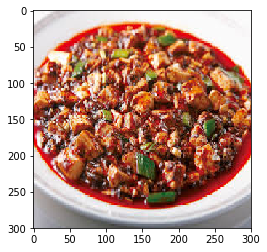

[0.8463907]
mabo_gekikara.jpegは麻婆豆腐です。


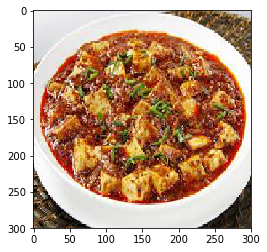

[0.5748211]
mabo_karai.jpegは麻婆豆腐です。


In [45]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  
  plt.imshow(img)
  plt.show()

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + "は麻婆豆腐です。")
  else:
    print(fn + "はカレーです。")